# Extract ROI

The goal of the notebook is to extract the regions of interest (ROIs) of a resting state image using a segmentation image. This notebook only deals with a subject but can easily be extended to multiple subjects.

## Working with real-world data


### Dowloading the Dataset

The first step is to download the dataset. Which you can find on this [website](https://db.humanconnectome.org/app/template/Login.vm;jsessionid=F82708079FFD7C01858D47841C617389). You will need to register yourself as an user to get acess to the data, but it should be straightforward. Once you have logged in, choose the project `WU-Minn HCP Data - 1200 Subjects` and dowload the dataset for one subject. 

You will need to download the anatomical data and the resting state data separetly.



### Exploring and Visualising your Dataset

Hopefully, fsl installation runned smoothly and you can now use it to visualise brain images. 

**Exercise:** Try to get a fealing of how the anatomical and the resting state image look like. They are called  `T1w_restore.nii.gz` and `rfMRI_REST1_LR.nii.gz`/`rfMRI_REST1_RL.nii.gz`

Note: To use fsl you will need to call it from the terminal. 


Usually, when you have a new image you want to check if it is in the standard template coordinates or native space. In case your image is on native space you will need to register it to MNI. A simple way of doing that is by visualising the image using `fslview` and overlaying a template that is already on MNI space (e.g. `MNI152_T1_2mm.nii.gz`). If fsl complains that means that the image is not on the standard space. 

**Question:** Are both anatomical and functional image in the standart space?

If you are completly lost and have no idea of what I mean by MNI, you can take a look at this slides:
https://fsl.fmrib.ox.ac.uk/fslcourse/lectures/reg.pdf

### Segmentation Image

Together with this notebook you should have received a segmentation image (`seg_aparc_82roi_2mm.nii.gz`) and a text file called `Lookuptable`.

The segmenation image is a labeled atlas where each region has been labeled with a specific intensity. 

**Question:** Visualise the segmentation image using `fslview`. Where on the gui can you see the different intensities for each region?

The `Lookuptable` maps the different intensities used on the segmentation image to their corresponding label. 

Now that we are a bit more familiar with the dataset and the segmentation images, we can extract the regions of interest from the resting state image.

## Extract ROIs

First we need to load the required Python libraries. Libraries are like extensions to the base python that add functionality or help to make tasks more convenient to do.

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
%matplotlib inline  


Define paths to the data, segmentation image and where the result will be saved

In [3]:
base_path_data = os.path.join(os.path.sep, 'group', 'dynamics', 'HCP')
results_path = os.path.join(os.path.sep, 'home', 'jdafflon', 'code', 'msc_project', 'patrycja', 'data_out', 'extract_rois')
input_path = os.path.join(os.path.sep, 'group', 'dynamics', 'scz_dynamics', 'ucla-la5', 'data_in', 'voi_extraction')

resting_state_image_path = os.path.join(base_path_data, '100307', 'MNINonLinear', 'Results', 'rfMRI_REST2_LR', 'rfMRI_REST2_LR.nii.gz')
segmentation_image_path = os.path.join( input_path, 'seg_aparc_82roi_2mm.nii.gz')
lookuptable_file_path = os.path.join(input_path,'LookupTable')


Load the subjects resting state image, the segmentation image and the lookuptable using nibabel. (This might take a while)

In [4]:
resting_state_image = nib.load(resting_state_image_path)
resting_state_image_data = resting_state_image.get_data()

In [5]:
segmentation_image = nib.load(segmentation_image_path)
segmentation_image_data = segmentation_image.get_data()

In [6]:
lookuptable = np.genfromtxt(lookuptable_file_path,
                           names='numbers, regions, intensity',
                           dtype=None,
                           delimiter=',')

### Play a bit around with the images you have just loaded using nibabel.

For every label get the corresponding activity. Remember that we want to extract the label for each brain region for all time points.

In [7]:
 # How can you visualise the resting state image header? 
 resting_header = resting_state_image.header
print(resting_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [   4   91  109   91 1200    1    1    1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.          2.          2.          2.          0.72000003  0.          0.
  0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : FSL5.0
aux_file        : 
qform_code      : mni
sform_code      : mni
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 90.0
qoffset_y       : -126.0
qoffset_z      

In [8]:
# How can you get the dimensions of the image? What does each dimension mean?
ntpoints = resting_state_image_data.shape[3]

Extract the time series for a specific region at every time point using the segmentation image and the lookuptable. For each time point you should save the mean activity of the region of interest.

In [9]:
mask = np.zeros((resting_state_image.shape[0], resting_state_image.shape[1], resting_state_image.shape[2]))
avg = np.zeros((lookuptable['intensity'].shape[0], ntpoints))
for region in range(len(lookuptable)):
    mask_1region = np.zeros((resting_state_image.shape[0], resting_state_image.shape[1], resting_state_image.shape[2]))
    intensity = lookuptable['intensity'][region]
    boolean_region = np.isclose(segmentation_image_data, intensity, atol=.0)
    boolean_mask = np.where(boolean_region)
    mask[boolean_region] = 1
    mask_1region[boolean_region] = 1
    for t in range(ntpoints):
        data = resting_state_image_data[:, : ,:, t]
        data = data[boolean_mask[0], boolean_mask[1], boolean_mask[2]]
        avg[region, t] = data.mean()

In [11]:
print(avg)
avg.shape

[[ 11310.91503906  11209.3203125   11194.78125    ...,  11202.02246094
   11100.91894531  11170.21875   ]
 [ 10992.40234375  10891.60742188  10811.44433594 ...,  10763.4375
   10684.12304688  10808.70996094]
 [  9549.65917969   9457.953125     9570.57226562 ...,   9639.08496094
    9642.49316406   9656.39453125]
 ..., 
 [  7247.21435547   7217.98144531   7121.99023438 ...,   7109.25585938
    7136.71826172   7073.19433594]
 [ 11232.71386719  11177.27636719  11197.31054688 ...,  11321.66113281
   11303.51757812  11225.36816406]
 [ 12250.56347656  12194.83886719  12098.86230469 ...,  12256.10351562
   12257.29785156  12266.98535156]]


(82, 1200)

Save the results into a text file

In [44]:
np.savetxt(os.path.join(results_path, 'rois_timeseries.txt'), avg, delimiter='', fmt='%5e')

Just as an exercise let's visualise the matrix(mask) here.

**Note:** Make sure you have install nilearn in your environment.

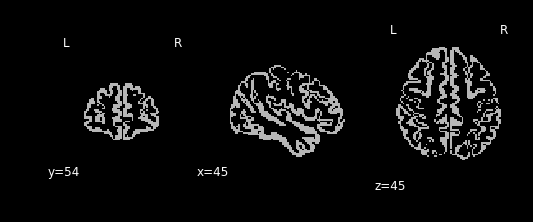

In [39]:
# create a nifti image for the mask
affine = resting_state_image.affine
mask_img = nib.Nifti1Image(mask, affine)
plotting.plot_anat(mask_img, draw_cross=False);

**Question:**Why does the mask look identical to the segmentation mask we used? How can we visualise the mask used only for region?? Folowing the above code which region would this be?

Lets visualise the connectivity matrix for one time point

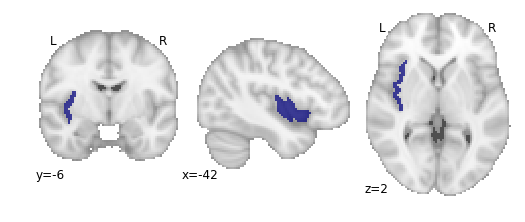

In [40]:
# The cut coordinates correspond to the second colomn of coordinats in fslview
mask_1region_img = nib.Nifti1Image(mask_1region, affine)
plotting.plot_roi(mask_1region_img, cut_coords=[-42,-6,2], draw_cross=False);